In [1]:
from typing import Optional
import os
import re
import pandas as pd
import numpy as np
import sympy
from scipy.interpolate import interp1d

import matplotlib.pylab as plt
import seaborn as sns

import gvar as gv
import lsqfit

In [2]:
def parse_label(fit, subs=True):
    expressions = {}
    values = {}
    for key, val in fit.p.items():
        if hasattr(val, "__iter__"):
            expr = sympy.symbols(" ".join([f"{key}{n}" for n, el in enumerate(val)]))
        else:
            expr = sympy.Symbol(key)

        expressions[key] = expr

        if hasattr(expr, "__iter__"):
            for ee, vv in zip(expr, val):
                values[sympy.latex(ee)] = vv
        else:
            values[sympy.latex(expr)] = val

    f_expr = fit.fcn(
        x=sympy.Symbol("x"), p={key: expr for key, expr in expressions.items()}
    )

    s = sympy.latex(f_expr)
    if subs:
        for pat, sub in values.items():
            s = s.replace(pat, str(sub))
            s = re.sub(r"e\+?([\-]?)[0]*([0-9]+)", " 10^{\g<1>\g<2>}", s)
    return re.sub(r"\+\s+\-", "-", s)

In [3]:
COLORS = sns.color_palette("hls", 2)


def plot_fit(fit: lsqfit.nonlinear_fit, ax: Optional[plt.Axes] = None) -> plt.Axes:
    """Plots a nonlinear_fit (data and fit result)."""
    _, ax = plt.subplots(figsize=(3, 2), dpi=300) if not ax else (None, ax)

    y_mean, y_sdev = gv.mean(fit.data[1]), gv.sdev(fit.data[1])
    ax.errorbar(
        fit.data[0],
        y_mean,
        y_sdev,
        marker="o",
        ms=2,
        ls="None",
        capsize=2,
        elinewidth=1,
        label="data",
        color=COLORS[0],
    )

    x_int = np.linspace(fit.data[0].min(), fit.data[0].max())
    y_fit = fit.fcn(x_int, fit.p)
    y_mean, y_sdev = gv.mean(y_fit), gv.sdev(y_fit)

    try:
        label = parse_label(fit)
        label = f"$f(x) = {label}$"
    except Exception as e:
        print(e)
        label = str(fit.p)

    ax.fill_between(
        x_int, y_mean - y_sdev, y_mean + y_sdev, color=COLORS[1], alpha=0.5, label="fit"
    )

    ax.legend(
        fancybox=False, frameon=False, bbox_to_anchor=(1.1, 0.5), loc="center left"
    )
    ax.set_title(label, size=8)

    return ax

In [4]:
HBARC = 197.3269804
MN = 938.918

In [5]:
DATA = "/home/ckoerber/data"
DATA_4HE_AV18 = "/home/ckoerber/data/nuc/4he/av18"
DATA_FF = "/home/ckoerber/data/nuc/NucleonFFData"
files = [f for f in os.listdir(DATA_4HE_AV18) if f.endswith(".dat")]

In [6]:
files[0]

'compton-dens-4he-av18-empot-no3nf-om=6.00E+01-th=1.80E+02-nx=16-nphi=16-np12=np34=28+8-np3=36+8-nq4=nq=36+6-j12max=5-lmax=6-lsummax=14-tau4max=0-rho1b.dat'

In [7]:
patterns = (
    r"compton-dens-(?P<nuc>[0-9A-z]+)",
    r"\-(?P<potential>[a-z0-9]+)",
    r"(?:\-(?P<empot>(?:empot)))?",
    r"(?:\-(?P<tnf>(?:[a-z0-9]+)))?",
    r"(?:\-Lamnum=(?P<lambda>(?:[0-9\.e\+]+)))?",
    r"(?:\-tnfcut=(?P<tnfcut>(?:[0-9]+)))?",
    r"\-om=(?P<omega>(?:[0-9\.]+E[\+\-][0-9]+))",
    r"\-th=(?P<theta>(?:[0-9\.E\+]+))",
    r"\-nx=(?P<nx>(?:[0-9]+))",
    r"\-nphi=(?P<nphi>(?:[0-9]+))",
    r"\-np12\=np34\=(?P<np12_np34>(?:[0-9\+]+))",
    r"\-np3\=(?P<np3>(?:[0-9\+]+))",
    r"\-nq4\=nq=(?P<nq4_nq>(?:[0-9\+]+))",
    r"\-j12max=(?P<j12max>(?:[0-9]+))",
    r"\-lmax=(?P<lmax>(?:[0-9]+))",
    r"\-lsummax=(?P<lsummax>(?:[0-9]+))",
    r"\-tau4max=(?P<tau4max>(?:[0-9]+))",
    r"\-rho1b\.dat",
)
pattern = re.compile("".join(patterns))
pattern.search(files[0]).groupdict()

{'nuc': '4he',
 'potential': 'av18',
 'empot': 'empot',
 'tnf': 'no3nf',
 'lambda': None,
 'tnfcut': None,
 'omega': '6.00E+01',
 'theta': '1.80E+02',
 'nx': '16',
 'nphi': '16',
 'np12_np34': '28+8',
 'np3': '36+8',
 'nq4_nq': '36+6',
 'j12max': '5',
 'lmax': '6',
 'lsummax': '14',
 'tau4max': '0'}

In [8]:
dtypes = {
    int: ["nx", "nphi", "j12max", "lmax", "lsummax", "tau4max"],
    float: ["lambda", "omega", "theta"],
}

In [9]:
data = [pattern.search(f).groupdict() for f in files]
df = pd.DataFrame(data)
for dtype, cols in dtypes.items():
    for col in cols:
        df[col] = df[col].astype(dtype)

df["file"] = files
df.head()

,nuc,potential,empot,tnf,lambda,tnfcut,omega,theta,nx,nphi,np12_np34,np3,nq4_nq,j12max,lmax,lsummax,tau4max,file
0,4he,av18,empot,no3nf,NaN,None,60.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-no3nf-om=6.00E+01-...
1,4he,av18,empot,urbix,100000000.0,3,0.0,180.0,8,12,28+8,36+8,36+6,4,6,14,0,compton-dens-4he-av18-empot-urbix-Lamnum=1.000...
2,4he,av18,empot,no3nf,NaN,None,98.7,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-no3nf-om=9.87E+01-...
3,4he,av18,empot,urbix,100000000.0,3,0.0,180.0,8,4,28+8,36+8,36+6,4,6,14,0,compton-dens-4he-av18-empot-urbix-Lamnum=1.000...
4,4he,av18,empot,no3nf,NaN,None,80.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-no3nf-om=8.00E+01-...


Only varying quantities are omega and theta

In [10]:
pp = r"MAXRHO1BINDEX\s+\=\s+(?P<max_rho_index>[0-9]+)"
pp += r".*"
pp += r"RHO1BINDX\s+\=(?P<rho_index>[0-9\*\,\-\s]+)"
pp += r".*"
pp += r"\/\s+(?P<om_theta>[0-9\.\-\+E ]+\n)"
pp += r"\s+(?P<rho>[0-9\.\-\+E\s]+\n)"


def parse_fortran_funny(string):
    for pat, subs in {
        f"{key}*{val}": ", ".join([val] * int(key))
        for key, val in set(
            re.findall(r"([0-9]+)\*([\-0-9]+)", re.sub(r"\s+", " ", string))
        )
    }.items():
        string = string.replace(pat, subs)

    arr = np.array(list(map(int, string.split(","))))
    nd = len(arr) // 8
    return pd.DataFrame(
        data=arr.reshape([nd, 8]),
        columns=[
            "ms3_x2",
            "mt3_x2",
            "mjtot_x2",
            "ms3p_x2",
            "mt3p_x2",
            "mjtotp_x2",
            "k",
            "bk",
        ],
    )


parse = {
    "max_rho_index": int,
    "om_theta": lambda el: np.array([float(ee) for ee in el.split(" ") if ee]),
    "rho": lambda el: np.array([float(ee) for ee in el.split(" ") if ee]),
    "rho_index": parse_fortran_funny,
}


def parse_1bd(address):
    with open(address, "r") as inp:
        t = inp.read()
    dd = re.search(pp, t, re.MULTILINE | re.DOTALL).groupdict()
    for key, val in parse.items():
        dd[key] = val(dd[key])
    return dd

In [11]:
f = df.query("omega == 0").file.values[0]
dens = parse_1bd(os.path.join(DATA_4HE_AV18, f))

k and bk encode angular dependence of the one-body operator
$$
O_{1} ( \vec k_{1} \  \mu' \mu \   \nu  \  \vec k ' \vec k ) \equiv \sum_{K=0}^{1}\sum_{\kappa=-K}^{K} \sqrt{\frac{4\pi}{2K+1}} \, k_{1}^{K} \, Y_{K\kappa}(\hat k_{1})
\tilde O_{1} ( K \kappa \  \mu' \mu \   \nu  \  \vec k ' \vec k )
$$
This would suggest, for the identity operation, $k = b_k = 0$.

In [12]:
inds = dens["rho_index"].query("k == bk == 0").index
dens["rho"][inds].sum(), dens["rho"][8:].sum()

(0.9947641492, -3.129739664764363e-10)

In [13]:
query = (
    "k == bk == 0"
    " and mt3_x2 == mt3p_x2"
    " and mjtot_x2 == mjtotp_x2"
    " and ms3_x2 == ms3p_x2"
)


def compute_norm(data, ms3_x2=None):
    qquery = query + " and ms3_x2 == @ms3_x2" if ms3_x2 is not None else query
    id_channels = data["rho_index"].query(qquery).index
    return data["rho"][id_channels].sum()


def compute_norm_from_file(ff, data=DATA_4HE_AV18, ms3_x2=None):
    dd = parse_1bd(os.path.join(data, ff))
    return compute_norm(dd, ms3_x2=ms3_x2)


print("norm:", compute_norm(dens))
print("norm-p:", compute_norm(dens, ms3_x2=1))
print("norm-n:", compute_norm(dens, ms3_x2=-1))

norm: 0.9947641492
norm-p: 0.4973820746
norm-n: 0.4973820746


In [14]:
os.listdir(DATA_FF)

['proton_baseline_sep272019_RE8414.dat', 'Ye2017gyb_neutron_lookup.dat']

In [15]:
gp_data = (
    pd.read_csv(
        os.path.join(DATA_FF, "proton_baseline_sep272019_RE8414.dat"), sep="\s+",
    )
    .set_index("Q2")
    .rename(columns={"GEp/GD": "gep", "GMp/muGD": "gmp"})[["gep", "gmp"]]
)
gep = interp1d(gp_data.index, gp_data.gep.values, kind="cubic")
gmp = interp1d(gp_data.index, gp_data.gmp.values, kind="cubic")

In [16]:
gn_data = (
    pd.read_csv(os.path.join(DATA_FF, "Ye2017gyb_neutron_lookup.dat"), sep="\s+",)
    .set_index("Q2")
    .rename(columns={"GEn/GD": "gen", "GMn/muGD": "gmn"})[["gen", "gmn"]]
)
gen = interp1d(gn_data.index, gn_data.gen.values, kind="cubic")
gmn = interp1d(gn_data.index, gn_data.gmn.values, kind="cubic")

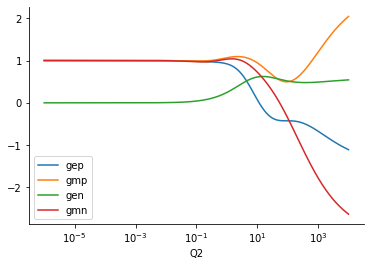

In [17]:
ax = gp_data.plot(y="gep")
gp_data.plot(y="gmp", ax=ax)
gn_data.plot(y="gen", ax=ax)
gn_data.plot(y="gmn", ax=ax)

ax.set_xscale("log")
ax.legend()
sns.despine()
plt.show()

In [18]:
def ge_correction(k2, rho, mt3_x2):
    gep_k2, gen_k2 = gep(k2), gen(k2)
    return (-k2 / 8 / MN ** 2 * np.where(mt3_x2 == 1, gep_k2, gen_k2) * rho).sum()

def compute_ge_correction_norm_from_file(ff, data=DATA_4HE_AV18):
    dd = parse_1bd(os.path.join(data, ff))
    iso_conserving = dd["rho_index"].query("mt3_x2 == mt3p_x2")
    rho = dd["rho"][iso_conserving.index]
    mt3_x2 = iso_conserving.mt3_x2.values
    q2 = (dd["om_theta"][0] * HBARC) ** 2
    if q2 == 0:
        q2 = 1.e-6
    return ge_correction(q2, rho, mt3_x2)

In [19]:
df["norm"] = df.file.apply(compute_norm_from_file)
df["norm_p"] = df.file.apply(compute_norm_from_file, ms3_x2=1)
df["ge_correction"] = df.file.apply(compute_ge_correction_norm_from_file)

In [20]:
qquery = {
    "theta": 180,
    "nuc": "'4he'",
    "potential": "'av18'",
    "tnf": "'no3nf'",
    "j12max": 5,
    "empot": "'empot'"
}
ddf = df.query(" and ".join(f"{key} == {val}" for key, val in qquery.items()))[
    ["omega", "norm", "norm_p", "ge_correction"]
].sort_values("omega")
ddf["q"] = ddf["omega"] * 2
ddf = ddf.set_index("q")

In [21]:
print(ddf[["norm", "ge_correction"]])

           norm  ge_correction
q                             
0.0    0.996737  -7.066520e-14
20.0   0.992843  -6.009120e-07
40.0   0.981216   7.887908e-07
60.0   0.962204   8.588463e-06
80.0   0.936306   2.315981e-05
98.6   0.906521   4.140528e-05
120.0  0.866665   6.541903e-05
140.0  0.824616   8.863944e-05
160.0  0.778968   1.104514e-04
180.0  0.730687   1.291556e-04
197.4  0.687462   1.418488e-04


Nucleus
{'theta': 180, 'nuc': "'4he'", 'potential': "'av18'", 'tnf': "'no3nf'", 'j12max': 5, 'empot': "'empot'"}

 fit function: c x^{2} + 1 

Least Square Fit:
  chi2/dof [dof] = 0.74 [9]    Q = 0.67    logGBF = 18.108

Parameters:
              c   -8.94(17)e-06      [ -1.0 (1.0) ]  

Fit:
     x[k]           y[k]        f(x[k],p)
-----------------------------------------
        0    0.9967 (65)            1 (0)  
       20    0.9928 (65)    0.996423 (70)  
       40    0.9812 (65)     0.98569 (28)  
       60    0.9622 (65)     0.96781 (63)  
       80    0.9363 (65)      0.9428 (11)  
     98.6    0.9065 (65)      0.9131 (17)  *
      120    0.8667 (65)      0.8712 (25)  
      140    0.8246 (65)      0.8247 (34)  
      160    0.7790 (65)      0.7711 (45)  *

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 3/0.0)
  fitter = scipy_least_squares    method = trf

r0^2 = sqrt(-6*c1) * hbarc : 1.445(14)


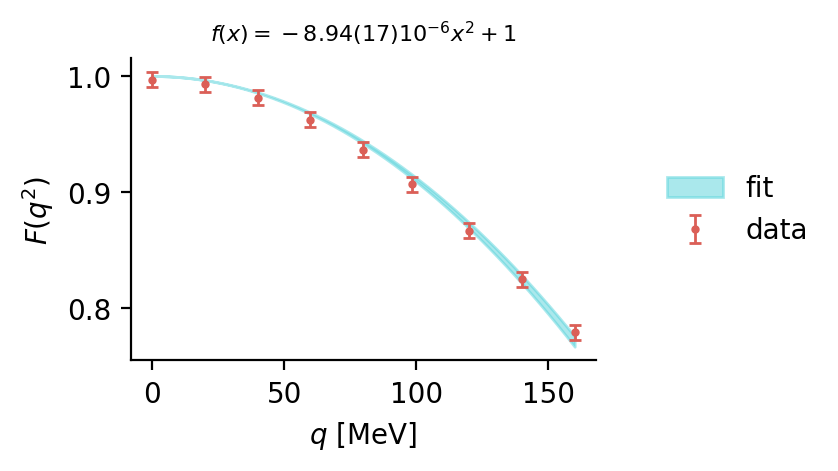

In [22]:
tmp = ddf.loc[:160]
x = tmp.index.values
y = gv.gvar(tmp.norm.values, [(1 - ddf.norm.loc[0]) * 2] * tmp.shape[0])


def poly_x2(x, p):
    res = 1
    if hasattr(p["c"], "__iter__"):
        for n, cn in enumerate(p["c"]):
            res += x ** (2 * n + 2) * cn
    else:
        res += x ** (2) * p["c"]
    return res


prior = {"c": gv.gvar(-1, 1)}

fit = lsqfit.nonlinear_fit((x, y), fcn=poly_x2, prior=prior)

print("Nucleus")
print(qquery)
print("\n fit function:", parse_label(fit, subs=False), "\n")
print(fit.format(maxline=True))
print("r0^2 = sqrt(-6*c1) * hbarc :", gv.sqrt(-fit.p["c"] * 6) * HBARC)

fig, ax = plt.subplots(dpi=200, figsize=(3, 2))
plot_fit(fit, ax=ax)
ax.set_ylabel("$F(q^2)$")
ax.set_xlabel("$q$ [MeV]")
sns.despine()
plt.show()